In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import itertools
# import plotly.express as pltly
# import plotly
import pandas as pd
# from functools import partial
import networkx as net
from utils import seq_scheduling
# import plotly.graph_objects as go

In [2]:
np.set_printoptions(suppress = True)

arameters for $\mu-L$ convergence
* $\mu = 2\lambda$       regularization parameter

In [3]:
K = 20
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .002
# L = max(lambda_base) + lamda
L = .1581 + .002
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
bar_sigma_sqr= 1.
a0 = 20 # initial distance between the average model parameter and the optimal one

In [4]:
np.random.seed(2)

num_lack_max = 4
num_lack = np.random.randint(0,num_lack_max+1,(K,))
for k in range(K):
    arr = np.ones((10,))
    arr[:num_lack[k]] = 0
    np.random.shuffle(arr)
        
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
# PL = A0 * ((D / d0) ** (-gamma))
d = 7850
# N = 7943
# barP = 2e-6
# M = 10 # the chromatic number for the digital scheme
N0 = 10 ** (-169/10) * 1e-3

# Set distances among any pair of nodes
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = 125 * np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma)) 

Some useful $\lambda$ expressions

In [6]:
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

tilde_p_t= lambda t, delta, beta, omega, tilde_N0:  -(delta**2 /4 + 2*beta**2 /omega) * (zeta0(delta,beta,omega))**2 / ( (tilde_N0)**(.25)*t/a_prime+1 )**2 + delta*zeta0(delta,beta,omega)/( (tilde_N0)**(.25)*t/a_prime+1 )
p_t = lambda t, delta, beta, omega, tilde_N0: np.minimum(tilde_p_t(t, delta, beta, omega, tilde_N0), p(delta, beta, omega))

C = lambda delta, beta, omega, tilde_N0: 1/K**2 * ( zeta0(delta, beta, omega)*a_prime*omega )**2 *d*mu/3.25*(tilde_N0)**0.5
A = lambda delta, beta, omega: delta * ( zeta0(delta, beta, omega)*a_prime )**3 * (2-omega)*omega**2*d*((mu/3.25)**2)

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=2000$**

934018.6303141749 | 934018.6303141749
700415.1622812315 | 700415.1622812315
525237.2743233478 | 525237.2743233478
393872.39054064115 | 393872.39054064115
295362.62488235836 | 295362.62488235836
221490.72205251487 | 221490.72205251487
166094.60988804547 | 166094.60988804547
124553.38615637853 | 124553.38615637853


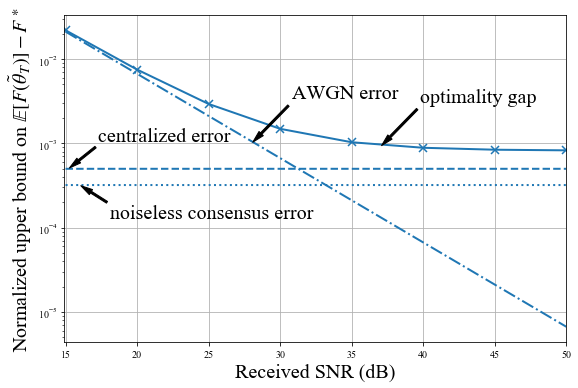

In [13]:
d = 7850
N = 10000
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.00001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
a = 7e6

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

schedule_list, Tx_times = seq_scheduling(G)
m = int(N / (2 * len(schedule_list) ))
omega = m / d
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape) # centralized error induced term
og1_partII_array= np.ones(barP_array.shape) # consensus-error induced term
og1_partIII_array = np.ones(barP_array.shape) # AWGN induced term
for n, barP in zip(range(len(barP_array)), barP_array):
    tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
    a_prime = a * tilde_N0_T**(.25) 
#     print(f'{a} | {max(5/p_t(T1,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
    print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
#     a_prime = 5.4e4
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta,beta,omega) /K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta, beta, omega, tilde_N0_T)
    
    og1_partII_array[n] = (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1)

    og1_partIII_array[n] = (158.45 * A(delta,beta,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1) + \
    + C(delta, beta, omega, tilde_N0_T)

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta,beta,omega) /K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta, beta, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta, beta, omega, tilde_N0_T)
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partIII_array/og1_ini_array, lw = 2.0, ls = '-.', color = 'C0', label = r'AWGN induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 20)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 20)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (37, 0.00091), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'noiseless consensus error',
            xy = (16, 0.00032), xycoords = 'data',
            xytext = (30, -33), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (15.2, 0.0005), xycoords = 'data',
            xytext = (30, 28), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'AWGN error',
            xy = (28, 0.0010), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_SNR_small_T.eps',format='eps', dpi=600)
plt.show()      

In [144]:
(og1_array/og1_ini_array)[4]

0.0009264045925880865

In [162]:
(og1_partIII_array/og1_ini_array)[3]

0.0006685682869219098

In [161]:
(og1_partII_array/og1_ini_array)[3]

0.00032071402480795625

In [150]:
(og1_partI_array/og1_ini_array).max()

0.000499857349547687

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=5000$**

934018.6303141749 | 934018.6303141749
700415.1622812315 | 700415.1622812315
525237.2743233478 | 525237.2743233478
393872.39054064115 | 393872.39054064115
295362.62488235836 | 295362.62488235836
221490.72205251487 | 221490.72205251487
166094.60988804547 | 166094.60988804547
124553.38615637853 | 124553.38615637853


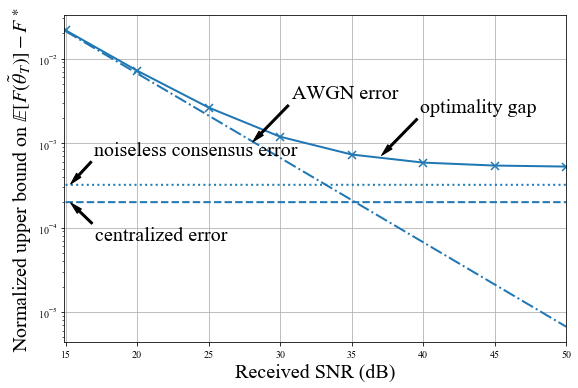

In [18]:
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.00001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
a = 7e6

T0 = 0
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

schedule_list, Tx_times = seq_scheduling(G)
m = int(N / (2 * len(schedule_list) ))
omega = m / d
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape) # centralized error induced term
og1_partII_array= np.ones(barP_array.shape) # consensus-error induced term
og1_partIII_array = np.ones(barP_array.shape) # AWGN induced term
for n, barP in zip(range(len(barP_array)), barP_array):
    tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
    a_prime = a * tilde_N0_T**(.25) 
#     print(f'{a} | {max(5/p_t(T1,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
    print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
#     a_prime = 5.4e4
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta,beta,omega) /K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta, beta, omega, tilde_N0_T)
    
    og1_partII_array[n] = (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1)

    og1_partIII_array[n] = (158.45 * A(delta,beta,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta, beta, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta, beta, omega, tilde_N0_T)

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta,beta,omega) /K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta, beta, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta, beta, omega, tilde_N0_T)
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partIII_array/og1_ini_array, lw = 2.0, ls = '-.', color = 'C0', label = r'AWGN induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 20)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 20)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (37, 0.00069), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'noiseless consensus error',
            xy = (15.3, 0.00032), xycoords = 'data',
            xytext = (24, 30), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (15.3, 0.0002), xycoords = 'data',
            xytext = (25, -38), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'AWGN error',
            xy = (28, 0.0010), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_SNR_large_T.eps',format='eps', dpi=600)
plt.show()       

In [177]:
(og1_array/og1_ini_array)[4]

0.0007317656060401445

In [180]:
(og1_partII_array/og1_ini_array).max()

0.00032057831850823825

In [178]:
(og1_partI_array/og1_ini_array).max()

0.00019985736343479128

The path loss will be **assumed the same** in the sequel for the sake of comparision the pure effect of topologies.

In [183]:
D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=2000$**

3374047.9511420946 | 1687023.9755710473
30000000.0 | 3531.000000000003
30000000.0 | 30089.588278868247
30000000.0 | 247588.79617187456
30000000.0 | 288854.9047619072


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


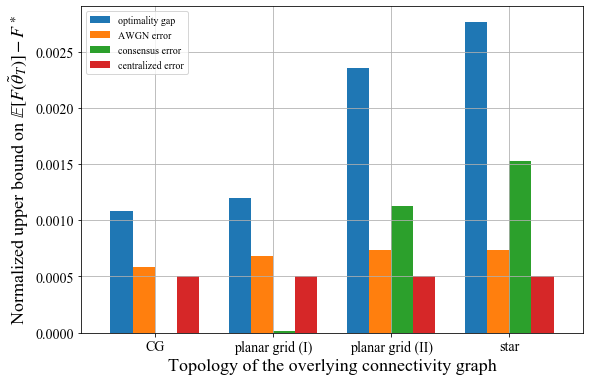

In [338]:
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.00001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
barP = 2e-7
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
a = 3e7
a_prime = a * tilde_N0_T**(.25) * 2
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

M = K
m = int(N / M)
omega = m / d
N = 10000
# opt = 0.41

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error
og1_partIII_list = [] # store the AWGN error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta1,beta1,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta1, beta1, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta1, beta1, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta1, beta1, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta1, beta1, omega, tilde_N0_T) )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta2,beta2,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta2, beta2, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta2, beta2, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta2, beta2, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta2, beta2, omega, tilde_N0_T) )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta3, beta3,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta3, beta3, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta3, beta3, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta3, beta3, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta3, beta3, omega, tilde_N0_T) )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta4, beta4,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta4, beta4, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta4, beta4, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta4, beta4, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta4, beta4, omega, tilde_N0_T) )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'AWGN error', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['AWGN error'] = np.array(og1_partIII_list) /np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax, rot = 0, fontsize = 14)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_topology_small_T.eps',format='eps', dpi=600)
plt.show()

In [332]:
df1

,optimality gap,AWGN error,consensus error,centralized error
CG,0.001084,0.000584,2.284043e-07,0.0005
planar grid (I),0.001201,0.000684,1.658653e-05,0.0005
planar grid (II),0.002356,0.000733,1.123019e-03,0.0005
star,0.002764,0.000735,1.528568e-03,0.0005


In [220]:
og1_list

[141.60192144935272,
 157.94665232492062,
 1078.5695511692945,
 1415.5448328997882]

In [221]:
og1_ini_list

[246155.37804167598, 246154.03567081506, 246153.8362683535, 246153.83205004924]

In [333]:
(np.array(og1_partII_list)/np.array(og1_ini_list)).max()

0.001528567952065347

In [334]:
(np.array(og1_partIII_list)/np.array(og1_ini_list)).max()

0.0007354397265785674

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=5000$**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3374047.9511420946 | 1687023.9755710473
30000000.0 | 3531.000000000003
30000000.0 | 30089.588278868247
30000000.0 | 247588.79617187456
30000000.0 | 288854.9047619072


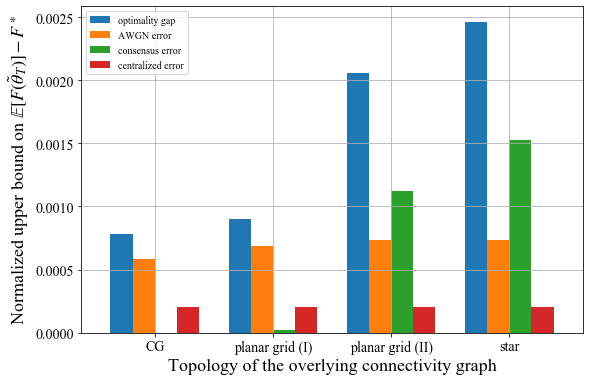

In [339]:
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.00001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
barP = 2e-7
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
a = 3e7
a_prime = a * tilde_N0_T**(.25) * 2
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

M = K
m = int(N / M)
omega = m / d
N = 10000
# opt = 0.41

T0 = 0
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error
og1_partIII_list = [] # store the AWGN error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta1,beta1,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta1, beta1, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta1, beta1, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta1, beta1, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta1,beta1,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta1, beta1, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta1, beta1, omega, tilde_N0_T) )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta2,beta2,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta2, beta2, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta2, beta2, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta2, beta2, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta2,beta2,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta2, beta2, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta2, beta2, omega, tilde_N0_T) )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta3, beta3,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta3, beta3, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta3, beta3, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta3, beta3, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta3, beta3,omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta3, beta3, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta3, beta3, omega, tilde_N0_T) )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

print(f'{a} | {max(5/p_t(T1,delta4, beta4,omega,tilde_N0_T), 13*L/mu)}')
# print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

og1_list.append( mu/3.25 * (a**3 - 3.25 * a**2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) ) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta4, beta4, omega, tilde_N0_T) )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * ( 24 * gb**2 ) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) )

og1_partIII_list.append( (158.45 * A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) * L * T1) / (mu**2 * ( p_t(T1, delta4, beta4, omega, tilde_N0_T) ) **2 * sT1) \
    + C(delta4, beta4, omega, tilde_N0_T) )
                       
og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * ( 24 * gb**2 + A(delta4, beta4, omega) / K * (tilde_N0_T)**(.25) ) * L * T0) / (mu**2 * ( p_t(T0, delta4, beta4, omega, tilde_N0_T) ) **2 * sT0) \
    + C(delta4, beta4, omega, tilde_N0_T) )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'AWGN error', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['AWGN error'] = np.array(og1_partIII_list) /np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax, rot = 0, fontsize = 14)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_topology_large_T.eps',format='eps', dpi=600)
plt.show()

In [336]:
(np.array(og1_partII_list)/np.array(og1_ini_list)).max()

0.0015284151088540152

In [337]:
(np.array(og1_partIII_list)/np.array(og1_ini_list)).max()

0.0007353662522578702